In [13]:
import torch
from torch.nn.utils.rnn import pad_sequence

# Example input: list of tensors with shape [1, t_i]
tensor_list = [torch.randn(5), torch.randn(7), torch.randn(3)]

# Remove the batch dimension (1), transpose to [t_i], to use pad_sequence
tensor_list_unbatched = [t for t in tensor_list]  # each becomes [t_i, 1]

# Pad the sequence to get shape [max_t, batch_size, 1]
padded = pad_sequence(tensor_list_unbatched, batch_first=True)  # shape: [batch_size, max_t, 1]

# Transpose back if you want shape [batch_size, 1, max_t]
# padded = padded.transpose(1, 2)  # shape: [batch_size, 1, max_t]

print(padded.shape)


torch.Size([3, 7])


In [19]:
padded.view(-1)

tensor([-1.1377,  1.0633, -2.1913,  0.1443,  0.8531,  0.0000,  0.0000,  0.9042,
        -0.1086,  0.0949, -0.8603, -1.3530, -0.3224,  0.3712, -0.2788, -0.5015,
        -0.2389,  0.0000,  0.0000,  0.0000,  0.0000])

In [15]:
tensor_list

[tensor([-1.1377,  1.0633, -2.1913,  0.1443,  0.8531]),
 tensor([ 0.9042, -0.1086,  0.0949, -0.8603, -1.3530, -0.3224,  0.3712]),
 tensor([-0.2788, -0.5015, -0.2389])]

log-mel shape: torch.Size([1, 80, 296])
Each second corresponds to 50 frames


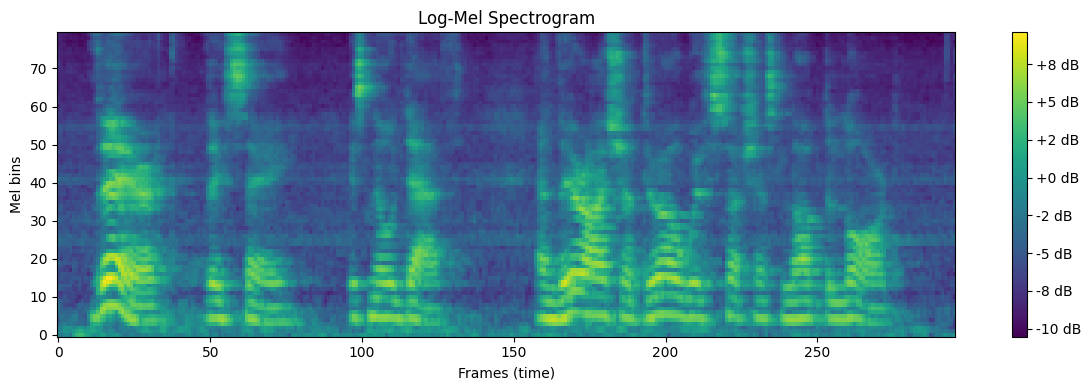

In [ ]:
import soundfile as sf
import torch
import torchaudio
import matplotlib.pyplot as plt
# Load with soundfile
waveform_np, sample_rate = sf.read("/raid/home/rajivratn/hemant_rajivratn/grpo/input.wav")

def mel_spec(waveform):
    waveform = torch.from_numpy(waveform).float().unsqueeze(0)

    # Set hop length for 50Hz frame rate
    target_frame_rate = 50
    hop_length = int(sample_rate / target_frame_rate)  # 320 if sr=16k
    n_fft = 1024
    n_mels = 80

    # Mel-spectrogram transform
    mel_spec_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
        center=True,
    )

    # Compute mel and log-mel
    mel_spec = mel_spec_transform(waveform)  # (channels, n_mels, time)
    log_mel_spec = torch.log(mel_spec + 1e-6)

    print(f"log-mel shape: {log_mel_spec.shape}")
    print(f"Each second corresponds to {target_frame_rate} frames")
    # Plotting the first channel (if stereo)
    plt.figure(figsize=(12, 4))
    plt.imshow(log_mel_spec[0].cpu().numpy(), aspect='auto', origin='lower',
               interpolation='none')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Frames (time)')
    plt.ylabel('Mel bins')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.show()
    return log_mel_spec # [1, 80, 296]


mel_spec(waveform_np)


In [10]:
94480 / 320

295.25

In [1]:
with open("/raid/home/rajivratn/hemant_rajivratn/last/data/txt/train.wrd", "r") as f:
    sentences = f.readlines()
sentences = [s for s in sentences if len(s) > 0]

In [ ]:
import kenlm

# Load the model (binary format loads faster)
model = kenlm.Model('/raid/home/rajivratn/hemant_rajivratn/grpo/charlm_5gram.arpa')

Loading the LM will be faster if you build a binary file.
Reading /raid/home/rajivratn/hemant_rajivratn/grpo/charlm_5gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************


In [26]:

# Sentence to score
sentence = ["this is a test", "TETSEXKURVTAMAEANUSOLIOD EZ IASEHPSIYURA DI EIMSKGLO ET EI OE E UHSHI NE EB EDBSOTLNLNOR W THNOLO T H TNACW ET H TNVLE TOTOTOPT PO N AIOASAUNE ESI NAR T EDALAC AOEPDUERSNE EMOER O EO SH RESHIA IUYENIEPMSL'EP NW EDMU N PGR R T EDEDCT EH MGL LNLE ETOLEO ODIS AEI DRNK"]
sentence = [i.replace(" ", "|").upper() for i in sentence]
sentence = [" ".join(i) for i in sentence]

for s in sentence:
    # Score (log10 probability)
    score = model.score(s)
    # Perplexity (optional)
    perplexity = 10 ** (-score / len(s))

    print(f"sentence: {s}, Score: {score}, Perplexity: {perplexity}")

sentence: T H I S | I S | A | T E S T, Score: -10.506513595581055, Perplexity: 2.4497971957151017
sentence: T E T S E X K U R V T A M A E A N U S O L I O D | E Z | I A S E H P S I Y U R A | D I | E I M S K G L O | E T | E I | O E | E | U H S H I | N E | E B | E D B S O T L N L N O R | W | T H N O L O | T | H | T N A C W | E T | H | T N V L E | T O T O T O P T | P O | N | A I O A S A U N E | E S I | N A R | T | E D A L A C | A O E P D U E R S N E | E M O E R | O | E O | S H | R E S H I A | I U Y E N I E P M S L ' E P | N W | E D M U | N | P G R | R | T | E D E D C T | E H | M G L | L N L E | E T O L E O | O D I S | A E I | D R N K, Score: -532.8903198242188, Perplexity: 10.170776285272106


In [4]:
counts

array([1.73055847e-01, 1.98678252e-01, 1.55467284e-01, 9.48820343e-02,
       6.98118144e-02, 9.08067134e-02, 2.39682429e-02, 1.38974938e-02,
       6.80841875e-03, 3.52349052e-03, 2.19358553e-03, 1.76440383e-04,
       4.30688227e-05, 1.40904173e-05, 3.36752112e-06, 2.74718828e-06,
       8.86189768e-08, 1.77237954e-07, 0.00000000e+00, 1.77237954e-07])

In [3]:
model_name="gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [4]:
sentences = ["123", "123"]
tokenizer(sentences, return_tensors="pt")

{'input_ids': tensor([[10163],
        [10163]]), 'attention_mask': tensor([[1],
        [1]])}

In [5]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [1]:
from collections import Counter
char_counter = Counter(
            [char for sentence in [" hello world "] for char in sentence if len(char) > 0]
        )
char_counter

Counter({' ': 3, 'l': 3, 'o': 2, 'h': 1, 'e': 1, 'w': 1, 'r': 1, 'd': 1})

In [7]:
{
            char: count / sum(char_counter.values())
            for char, count in char_counter.items()
        }

{' ': 0.23076923076923078,
 'h': 0.07692307692307693,
 'e': 0.07692307692307693,
 'l': 0.23076923076923078,
 'o': 0.15384615384615385,
 'w': 0.07692307692307693,
 'r': 0.07692307692307693,
 'd': 0.07692307692307693}

In [11]:
import torch
import re

# Define vocab (index 0 is blank)
vocab = ['_', 'a', 'b', 'c']
blank_id = 0

# Example model output (index sequence)
output = torch.tensor([1, 1, 0, 2, 2, 0, 2, 2, 3, 3, 0])

# Step 1: Collapse consecutive repeats
# Create a mask to keep only non-duplicate consecutive elements
mask = torch.ones_like(output, dtype=torch.bool)
mask[1:] = output[1:] != output[:-1]
collapsed = output[mask]
print(collapsed)
# Step 2: Remove blanks (i.e., tokens with index 0)
final = collapsed[collapsed != blank_id]
print(final)
# Step 3: Convert indices to characters using vocab
decoded_string = ''.join(vocab[i] for i in final.tolist())

print("Decoded string:", decoded_string)  # → 'bbc'


tensor([1, 0, 2, 0, 2, 3, 0])
tensor([1, 2, 2, 3])
Decoded string: abbc


In [15]:
mask

tensor([[ True, False, False,  True, False, False,  True, False,  True, False,
         False]])

In [36]:
import numpy as np
c = np.array(['a','b','c','d'])

4

In [4]:
c[filtered[0]]

array(['b', 'c', 'd'], dtype='<U1')

In [21]:
from transformers import ClapProcessor, ClapModel
import torch
import torchaudio
import soundfile as sf
import numpy as np

# Load model and processor
processor = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
model = ClapModel.from_pretrained("laion/clap-htsat-unfused")

# Load and preprocess audio
def load_audio(path):
    waveform, sr = torchaudio.load(path)
    if sr != 48000:
        resampler = torchaudio.transforms.Resample(sr, 48000)
        waveform = resampler(waveform)
    return waveform

audio_path = "/raid/home/rajivratn/hemant_rajivratn/librispeech/data/train/audio/train-clean-100_126791_298_53.wav"
audio = load_audio(audio_path)

# CLAP expects mono
if audio.shape[0] > 1:
    audio = torch.mean(audio, dim=0, keepdim=True)

# Pad or truncate to 10s (CLAP expects 480000 samples)
audio = torch.nn.functional.pad(audio, (0, max(0, 480000 - audio.shape[1])))[:, :480000]



In [24]:
"SPEAK I BEG WITHOUT DREAD OF MY DISPLEASURE SAID FRANCES RETURNING THE GOOD HUMORED SMILE OF THE TROOPER WITH THE ARCHNESS NATURAL TO HER OWN SWEET FACE THE ODORS OF YOUR KITCHEN THEN CRIED LAWTON BLUNTLY FORBID MY QUITTING THE DOMAINS UNTIL I QUALIFY MYSELF TO SPEAK WITH MORE CERTAINTY CONCERNING THE FATNESS OF THE LAND".lower()

'speak i beg without dread of my displeasure said frances returning the good humored smile of the trooper with the archness natural to her own sweet face the odors of your kitchen then cried lawton bluntly forbid my quitting the domains until i qualify myself to speak with more certainty concerning the fatness of the land'

In [30]:

# Process audio and text
texts = ["hello how are you", "this is a dog barking", "there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with", "speak i beg without dread of my displeasure said frances returning the good humored smile of the trooper with the archness natural to her own sweet face the odors of your kitchen then cried lawton bluntly forbid my quitting the domains until i qualify myself to speak with more certainty concerning the fatness of the land"]
inputs = processor(audios=audio.squeeze().numpy(), text=texts, return_tensors="pt", padding=True)

# Forward pass
with torch.no_grad():
    outputs = model(**inputs)
    audio_embeds = outputs.audio_embeds
    text_embeds = outputs.text_embeds

It is strongly recommended to pass the `sampling_rate` argument to `ClapFeatureExtractor()`. Failing to do so can result in silent errors that might be hard to debug.


In [31]:

# Normalize embeddings
audio_embeds = torch.nn.functional.normalize(audio_embeds, dim=-1)
text_embeds = torch.nn.functional.normalize(text_embeds, dim=-1)

# Cosine similarity
similarities = torch.matmul(audio_embeds, text_embeds.T).squeeze(0)

# Print ranked results
for text, score in sorted(zip(texts, similarities), key=lambda x: -x[1]):
    print(f"{text:<30} -> Similarity: {score.item():.4f}")


speak i beg without dread of my displeasure said frances returning the good humored smile of the trooper with the archness natural to her own sweet face the odors of your kitchen then cried lawton bluntly forbid my quitting the domains until i qualify myself to speak with more certainty concerning the fatness of the land -> Similarity: 0.5616
there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with there they say is no debt and there are a girl with -> Similarity: 0.5157
hello how are you              -> Similarity: 0.0358
this is a dog barking          -> Similarity: -0.1362


In [ ]:
import kenlm
model = kenlm.Model("/raid/home/rajivratn/hemant_rajivratn/grpo/3-gram.pruned.1e-7.arpa.gz")

sentence = "this is a test".upper()
print(sentence)

# Each tuple means “this word had log10-prob logp given the previous context; ng_len is the n-gram order (e.g. 3 means a trigram was used), and oov marks out-of-vocabulary
for (logp, ng_len, oov) in model.full_scores(sentence, bos=False, eos=False):
    print(logp, ng_len, oov)

In [ ]:
def unigram(sentences):
    for s in sentences:
        log10p = [model.score(w, bos=False, eos=False) for w in sentence.split() if model.vocab_index(w) != 0]

unigram([sentence])

In [ ]:
from collections import Counter

def get_unigram_char_probs(sentences):
    # Flatten to a list of characters
    chars = [char for sentence in sentences for char in sentence.strip()]
    
    # Count frequency of each character
    char_counts = Counter(chars)
    total_chars = sum(char_counts.values())

    # Convert to probabilities
    char_probs = {char: count / total_chars for char, count in char_counts.items()}
    
    return char_probs, chars

# Example usage
sentences = [
    'THANK YOU AGAIN MISTER DEVANT HE SAID...',
    'FOR WEEKS IT NEVER CAME TO MY TURN...',
    'ONE MAN WON PAST ME INDEED DARTING...'
]

char_probs, chars = get_unigram_char_probs(sentences)

# Print sorted for readability
for char, prob in sorted(char_probs.items()):
    print(f"'{char}': {prob:.5f}")

In [1]:
with open("/raid/home/rajivratn/hemant_rajivratn/last/data/txt/train_norm.txt", "r") as f:
    out = [i for i in f.readlines() if len(i.strip()) > 0]

In [ ]:
from tqdm import tqdm
def preprocess_char_lm(sentences):
    """Prep a list of sentences for char-level n-gram LM training."""
    preprocessed = []
    for s in tqdm(sentences):
        s = s.strip().replace(" ", "|")
        chars = list(s)
        line = "<s> " + " ".join(chars) + " </s>"
        preprocessed.append(line)
    return preprocessed

char_lm_lines = preprocess_char_lm(out)

100%|██████████| 40407482/40407482 [01:48<00:00, 373406.29it/s]


In [3]:
output_path = "char_lm_input.txt"

with open(output_path, "w", encoding="utf-8") as f:
    for line in char_lm_lines:
        f.write(line + "\n")

print(f"Saved to {output_path}")


Saved to char_lm_input.txt


In [ ]:
import torch
@torch.jit.script
def beam_search(log_probs: torch.Tensor, beam_size: int):
    """
    Performs beam search on a tensor of log probabilities.

    Args:
        log_probs (torch.Tensor): Tensor of shape (b, t, v) containing log probabilities.
        beam_size (int): Number of beams to keep at each time step.

    Returns:
        sequences (torch.Tensor): Tensor of shape (b, beam_size, t) containing the top sequences.
        scores (torch.Tensor): Tensor of shape (b, beam_size) containing the scores of the top sequences.
    """
    
    b, t, v = log_probs.size()
    
    initial_beam_size = min(beam_size, v) # At the very first step (time step 0), we can't have more beams than the vocabulary size. This line ensures that the initial number of beams considered doesn't exceed the number of possible first tokens.

    topk_scores, topk_indices = torch.topk(log_probs[:, 0, :], initial_beam_size, dim=-1) # Returns the k largest elements of the given input tensor along a given dimension
    sequences = topk_indices.unsqueeze(-1)  # (b, initial_beam_size, 1)
    scores = topk_scores  # (b, initial_beam_size)

    for step in range(1, t):
        # Expand the current sequences with all possible next tokens
        current_log_probs = log_probs[:, step, :].unsqueeze(1)  # (b, 1, v)
        expanded_scores = scores.unsqueeze(-1) + current_log_probs  # (b, beam_size, v)
        flat_scores = expanded_scores.view(b, -1)  # (b, beam_size * v)

        # Select the top-k scores and their corresponding indices
        topk_flat_scores, topk_indices = flat_scores.topk(beam_size, dim=-1)  # (b, beam_size)
        beam_indices = topk_indices // v  # Indices of sequences to expand
        token_indices = topk_indices % v  # New tokens to append

        # Gather the sequences to expand and append the new tokens
        sequences = torch.gather(sequences, 1, beam_indices.unsqueeze(-1).expand(-1, -1, sequences.size(-1)))
        sequences = torch.cat([sequences, token_indices.unsqueeze(-1)], dim=-1)  # (b, beam_size, step+1)

        # Update the scores
        scores = topk_flat_scores

    return sequences, scores.unsqueeze(-1)



In [ ]:
batch_size = 2
sequence_length = 5
vocab_size = 3
beam_size = 2

# Simulate log probabilities
log_probs = torch.randn(batch_size, sequence_length, vocab_size).log_softmax(dim=-1)
device = torch.device('cpu')
log_probs = log_probs.to(device)


In [ ]:
log_probs[1,3:,:] = -float("1000000")

In [ ]:
log_probs

In [ ]:
# Perform beam search
sequences, scores = beam_search(log_probs, beam_size)

print("Top sequences:", sequences) # bsz, beamsize,seq_len
print("Scores:", scores) # bsz, beamsize,1

In [ ]:
sequences.shape, scores.shape

In [ ]:
path_probs = torch.gather(log_probs, 2, sequences.transpose(1,2)).transpose(1,2) # bsz, beamsize, T
path_probs

In [ ]:
mean = scores.mean(dim=1, keepdim=True)
std = scores.std(dim=1, keepdim=True)

scores = (scores - mean) / std

In [ ]:
path_probs*scores

In [ ]:
sequences # bsz,beam,T

In [ ]:
# If using PyTorch
import torch

import re
import numpy as np


vocab = [' ', "'", 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '?']
vocab = np.array(vocab)


# Precompile regex to remove blanks and collapse repeats
blank_char = re.escape('?')  # adjust if blank differs
remove_blanks = re.compile(blank_char)
collapse_repeats = re.compile(r'(.)\1+')

# Convert token sequences to strings using regex merge
def decode(arr, vocab):
    raw = [collapse_repeats.sub(r'\1', remove_blanks.sub('', ''.join(vocab[row]))) for row in arr]
    return raw


In [ ]:
# Convert token sequences to strings using regex merge
def decode(arr, vocab):
    raw = [collapse_repeats.sub(r'\1', remove_blanks.sub('', ''.join(vocab[row]))) for row in arr]
    return raw

sentences = decode(sequences[0].cpu(), vocab)
sentences

In [ ]:
sequences[0], vocab

In [ ]:
arr = sequences[1,:,:]
arr

In [ ]:
import numpy as np
vocab_arr = np.array(vocab)

decoded = [''.join(vocab_arr[row]) for row in arr]
print(decoded)  # ['abc', 'cba']


In [ ]:
[collapse_repeats.sub(r'\1', remove_blanks.sub('', ''.join(vocab[row]))) for row in arr]

In [ ]:
[''.join(vocab[row]) for row in arr]

In [ ]:
decode(arr, vocab)

In [ ]:
'-'.join(vocab[np.array(arr)])

In [ ]:
import numpy as np

# Step 1: vocab and array of indices
vocab = ['a', 'b', 'c', 'd', 'e']
vocab_arr = np.array(vocab)  # shape (V,)
arr = np.array([
    [0, 1, 2],
    [2, 3, 4],
])  # shape (2, 3)

# Step 2: index vocab
char_matrix = vocab_arr[arr]  # shape (2, 3), dtype='<U1'

# Step 3: vectorized join — this is the key step!
joined = np.char.join('-', char_matrix)  # shape (2,), dtype='<U5' etc.

print(joined)  # Output: ['a-b-c' 'c-d-e']


In [ ]:
decoded = ['-'.join(vocab[row]) for row in arr]
decoded

In [ ]:

arr = torch.tensor([[0, 1, 2], [2, 1, 0]])
decoded = [''.join(vocab_arr[row]) for row in arr.numpy()]
print(decoded)  # ['abc', 'cba']


In [ ]:
sentences = [decode_one(seq, vocab) for seq in sequences[0,:,:].cpu().numpy()]

In [ ]:
# 1) move to CPU & to plain Python list of lists
sentences = []
for b in range(sequences.shape[0]):
    print(b)
    rows = sequences[b].cpu().tolist() # beam,T
    decoded_beams = [ctc_merge_string( ''.join(idx2char[i] for i in row) ) for row in rows]
    sentences.append(decoded_beams)
print(sentences)

In [ ]:
sentences

In [ ]:
def _decode_one( seq):
    chars = [vocab[i] for i in seq]
    raw = ''.join(chars)
    return raw


In [ ]:
sequences.shape

In [ ]:
_decode_one(sequences[0,0])

In [ ]:
"""
1.  beamctc decoder
2. 


"""